## Rupture

Truong, Charles, Laurent Oudre, and Nicolas Vayatis. "ruptures: change point detection in Python." arXiv preprint arXiv:1801.00826 (2018). ([arXiv](https://arxiv.org/abs/1801.00826))

公式ドキュメント：[ruptures documentation](https://centre-borelli.github.io/ruptures-docs/)

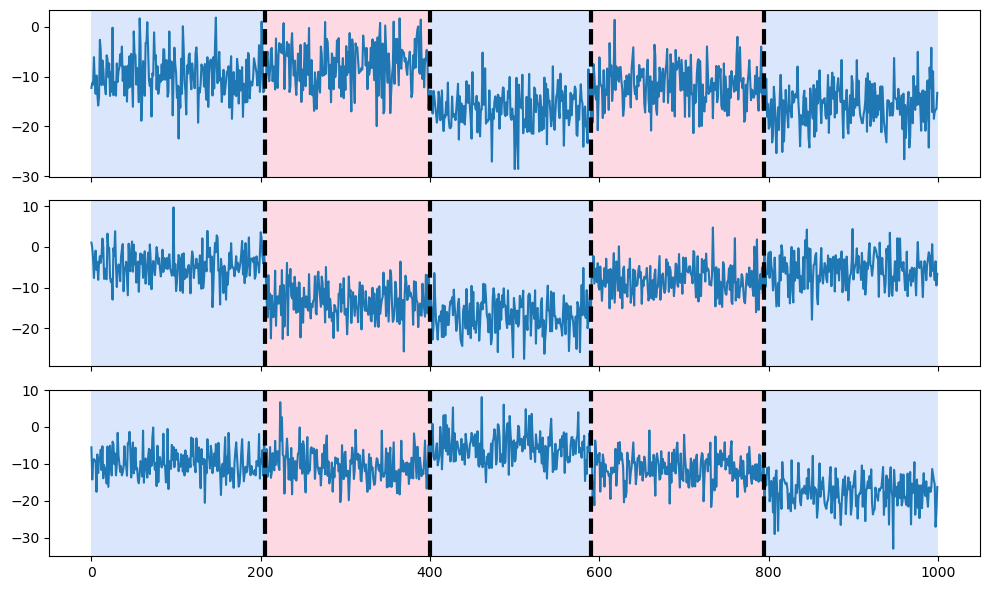

In [1]:
# seaborn内部のpandas使用箇所でFutureWarningが出ていたので表示しないようにする
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
import seaborn as sns

warnings.simplefilter(action="ignore", category=FutureWarning)

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

## さまざまなデータでの比較
### 変化点検出＋可視化のコード

In [2]:
def vizualize_change_point(
    signals, true_change_points=[], method="rbf", pen=0.5, min_size=3
):
    algo = rpt.Pelt(model=method, min_size=min_size).fit(signals)
    result = algo.predict(pen=pen)
    rpt.display(signals, true_change_points, result)
    plt.suptitle(f"method={method}, penalty={pen}, ", fontsize=20)
    plt.tight_layout()
    plt.show()

#### サンプルデータの作成

<Axes: >

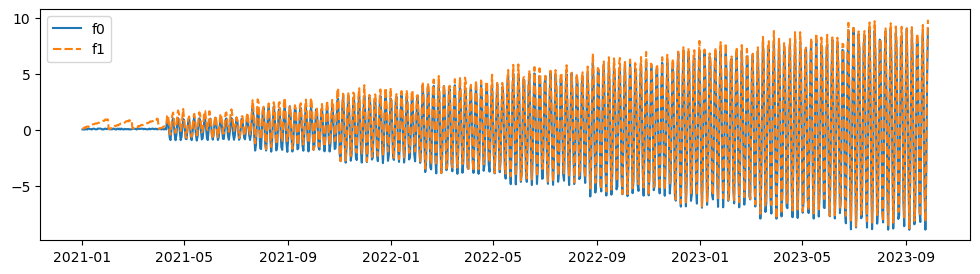

In [3]:
X = []
dates = [datetime(2021, 1, 1) + timedelta(days=i) for i in range(1000)]
for i, di in enumerate(dates):
    value = i // 100
    X.append(
        [
            np.sin(di.weekday() * 0.001) * 2
            + np.random.rand() * 0.1
            + value * np.cos(i),
            np.sin(di.day * 0.01) * 3 + np.random.rand() * 0.1 + value * np.cos(i),
        ]
    )

data = pd.DataFrame(X)
data.columns = [f"f{c}" for c in data.columns]
data.index = dates

plt.figure(figsize=(12, 3))
sns.lineplot(data=data)

#### ペナルティの違いによる結果の違い

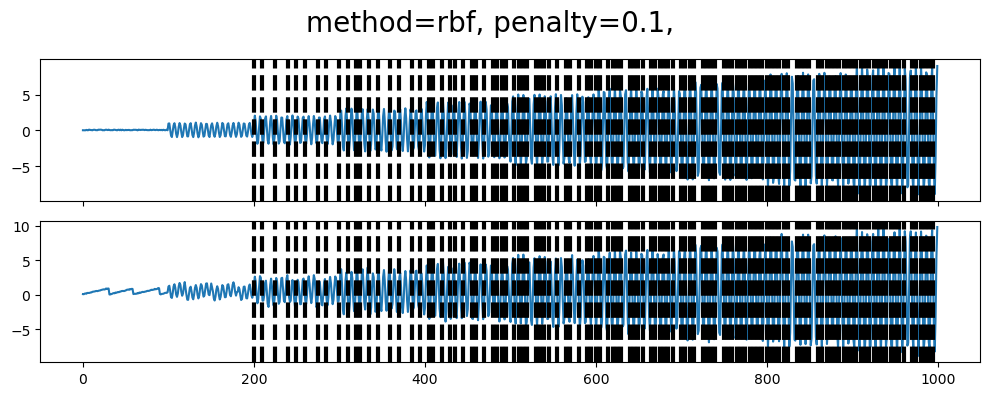

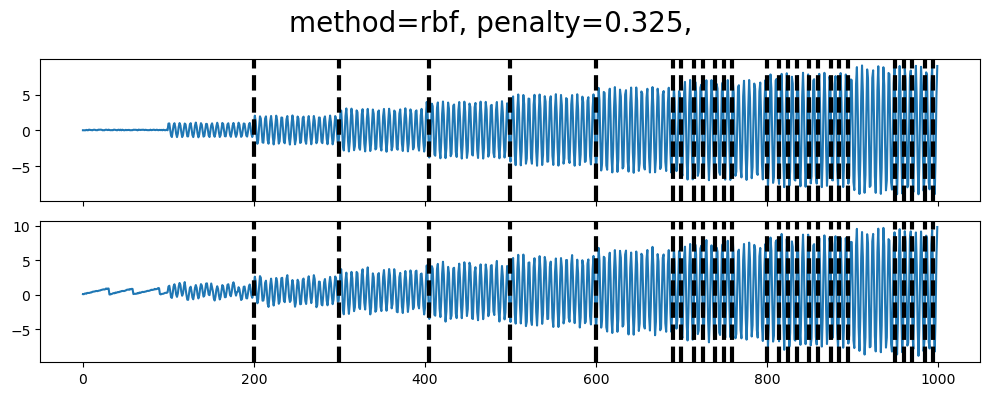

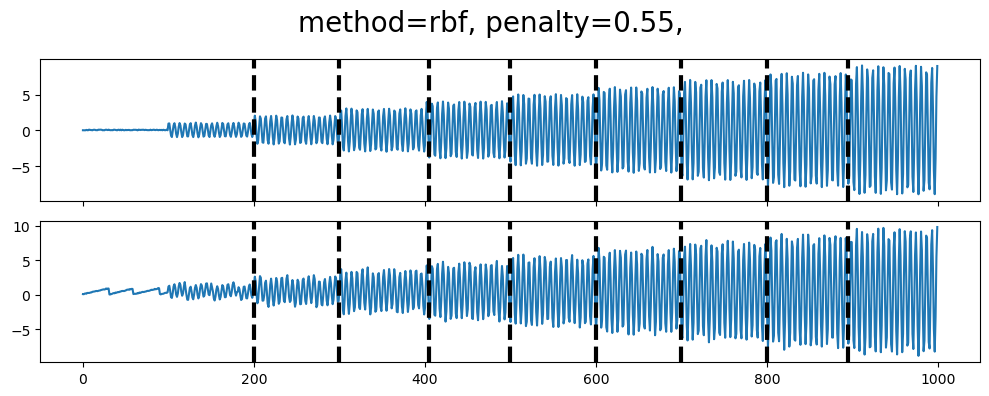

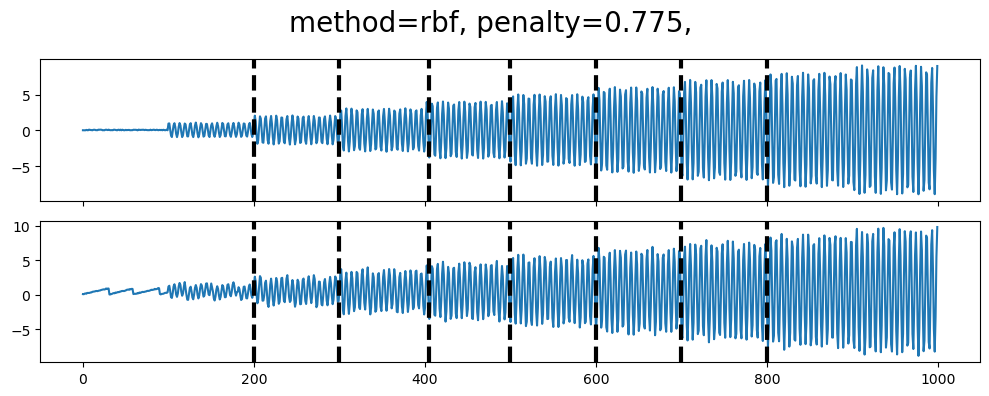

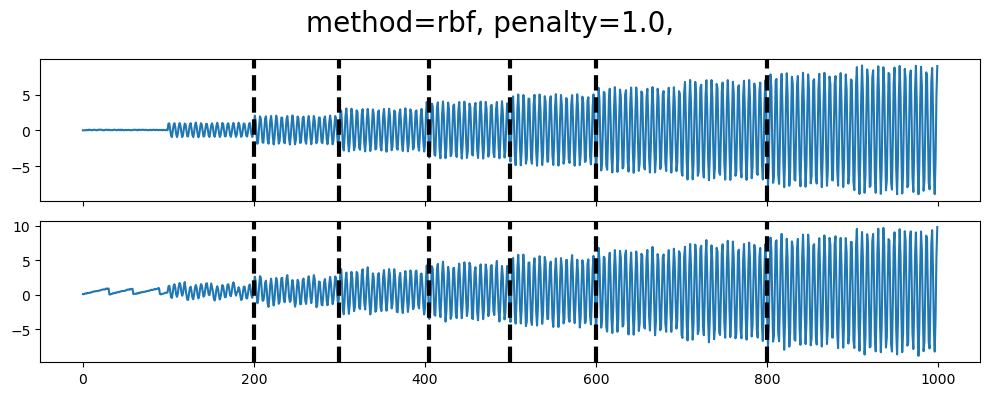

In [4]:
for pen in np.linspace(0.1, 1, 5):
    vizualize_change_point(data.values, method="rbf", pen=pen)

### 動的計画法を使った変化点の検出
動的計画法を使う場合、変化点の数（`n_bkps`）をあらかじめ指定する必要がある。

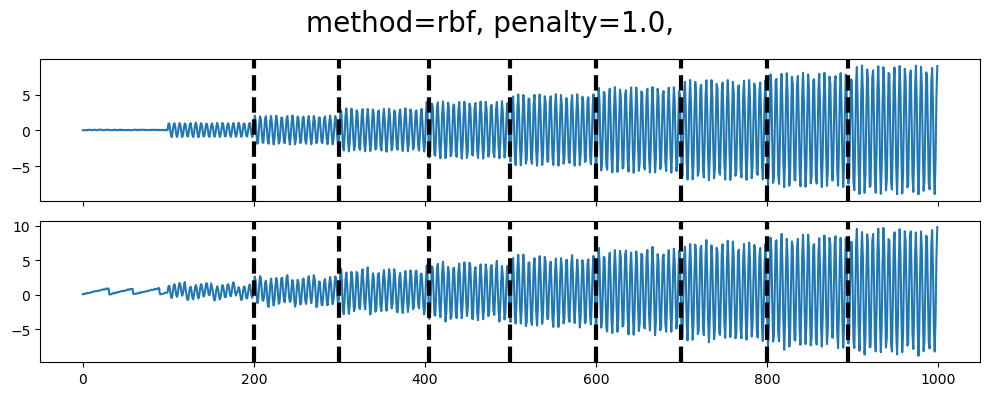

In [5]:
def vizualize_change_point_dynp(
    signals, true_change_points=[], method="rbf", min_size=3, n_bkps=3
):
    algo = rpt.Dynp(model=method, min_size=min_size).fit(signals)
    result = algo.predict(n_bkps=n_bkps)
    rpt.display(signals, true_change_points, result)
    plt.suptitle(f"method={method}, penalty={pen}, ", fontsize=20)
    plt.tight_layout()
    plt.show()


vizualize_change_point_dynp(
    data.values, true_change_points=[], method="rbf", min_size=3, n_bkps=8
)

## 人工データでの実験2
移動平均は大体いつもおなじだけれど、分散がある時点で変化するデータです。

(0.0, 1.0)

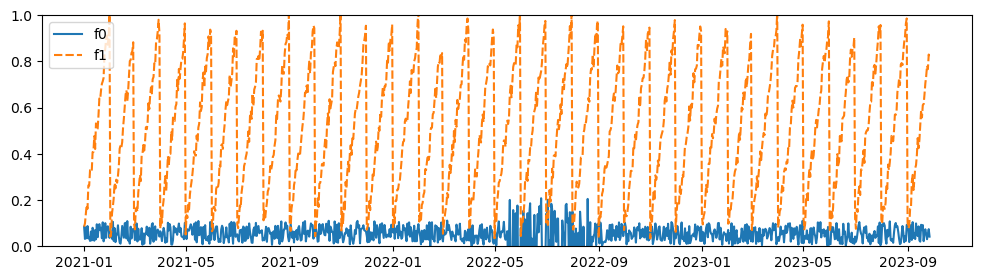

In [6]:
X2 = []
dates2 = [datetime(2021, 1, 1) + timedelta(days=i) for i in range(1000)]
for i, di in enumerate(dates2):
    if i == 550:
        X2.append(
            [
                np.sin(di.weekday() * 0.001) * 2 + np.random.rand() * 0.1,
                np.sin(di.day * 0.01) * 3 + np.random.rand() * 0.1,
            ]
        )
    elif 500 < i < 600:
        X2.append(
            [
                np.sin(di.weekday() * 0.001) * 2
                + np.random.rand() * 0.1
                + np.random.randint(-2, 2) * 0.1,
                np.sin(di.day * 0.01) * 3 + np.random.rand() * 0.1,
            ]
        )
    else:
        X2.append(
            [
                np.sin(di.weekday() * 0.001) * 2 + np.random.rand() * 0.1,
                np.sin(di.day * 0.01) * 3 + np.random.rand() * 0.1,
            ]
        )


data2 = pd.DataFrame(X2)
data2.columns = [f"f{c}" for c in data2.columns]
data2.index = dates2

plt.figure(figsize=(12, 3))
sns.lineplot(data=data2)
plt.ylim(0, 1)

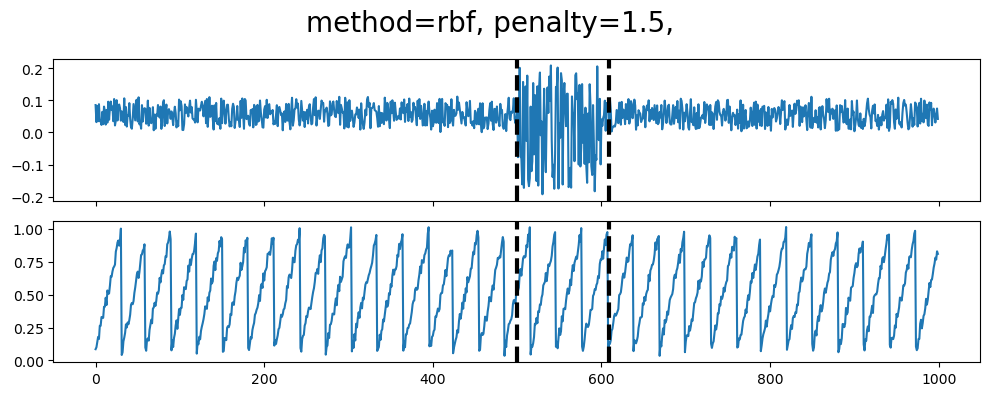

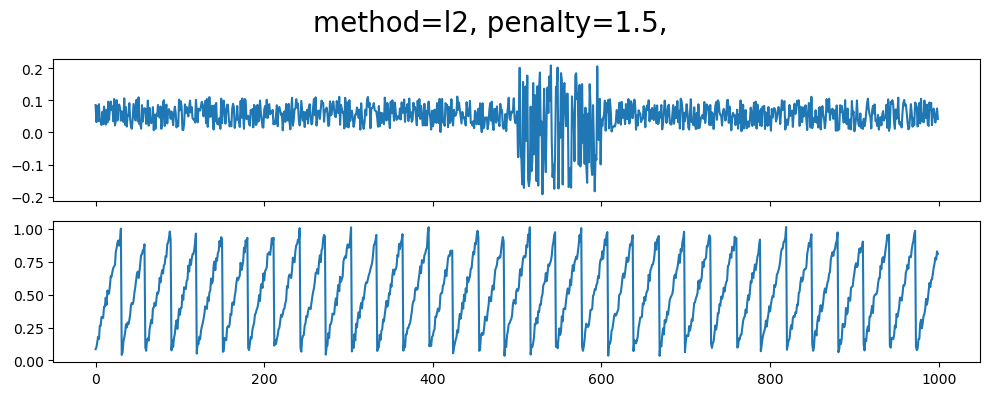

In [7]:
# 注意点：値の絶対値や損失関数によって指定すべきpenaltyの値は異なる
vizualize_change_point(data2.values, method="rbf", pen=1.5, min_size=50)
vizualize_change_point(data2.values, method="l2", pen=1.5, min_size=50)

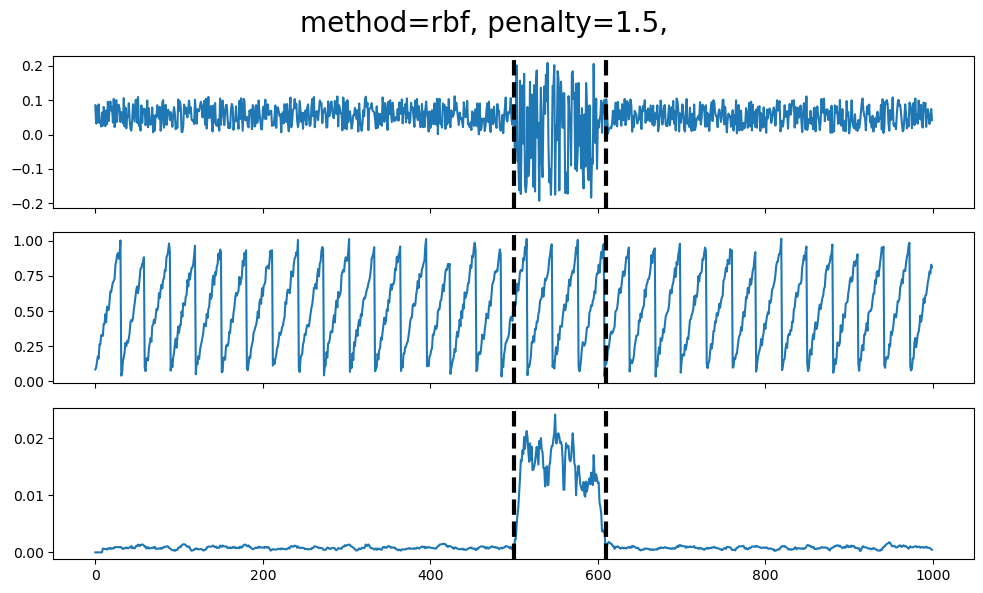

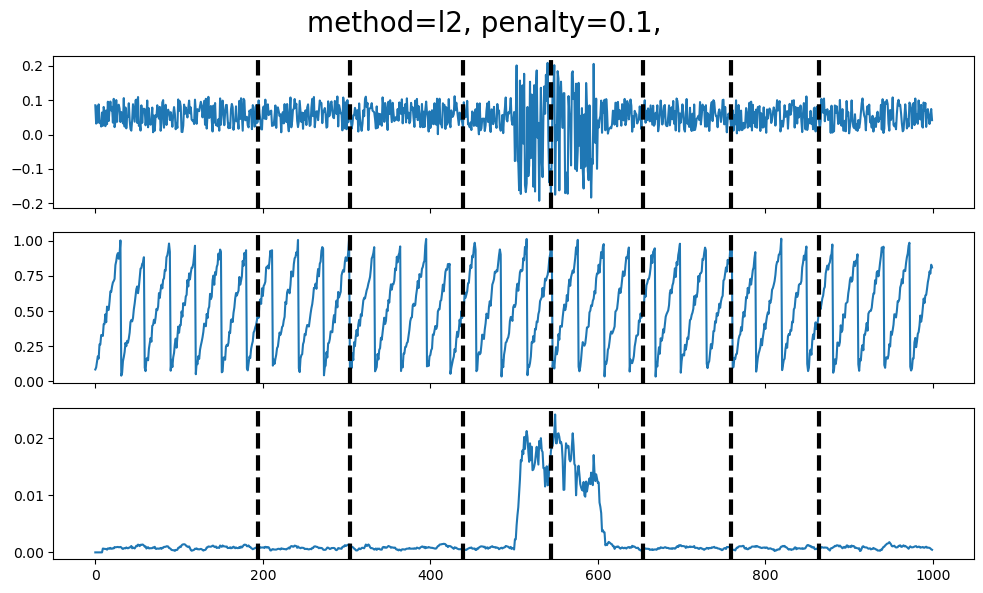

In [8]:
data2["var"] = data2["f0"].rolling(window=10).var().fillna(0)
vizualize_change_point(data2.values, method="rbf", pen=1.5, min_size=50)
vizualize_change_point(data2.values, method="l2", pen=0.1, min_size=100)

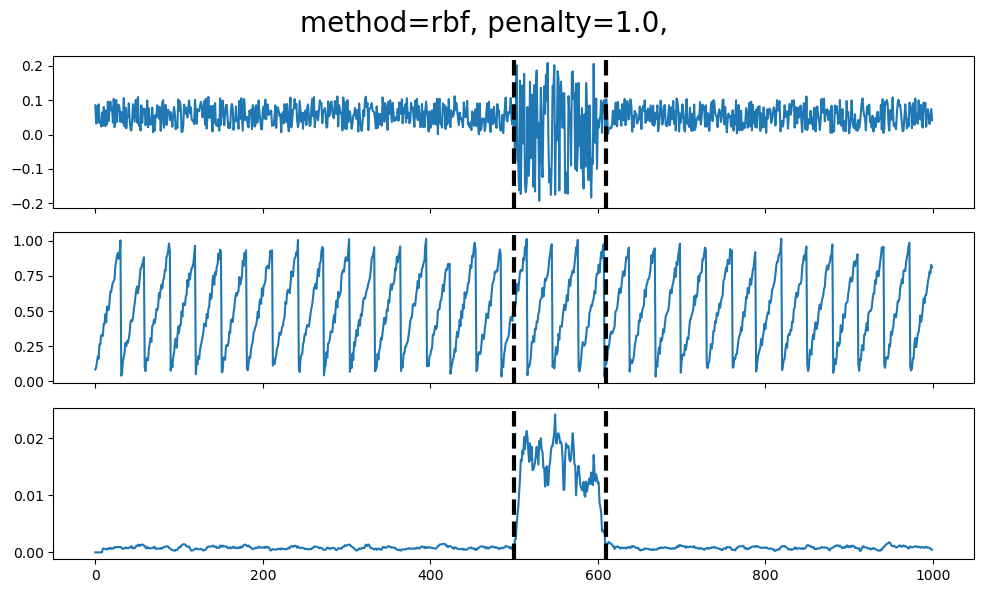

In [9]:
vizualize_change_point_dynp(data2.values, min_size=90, n_bkps=2)

## 実データでの実験
[Yahoo financeのDDOGのデータ](https://finance.yahoo.com/quote/DDOG/history?period1=1676077845&period2=1707613845&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)を使って変化点を見てみようと思います。

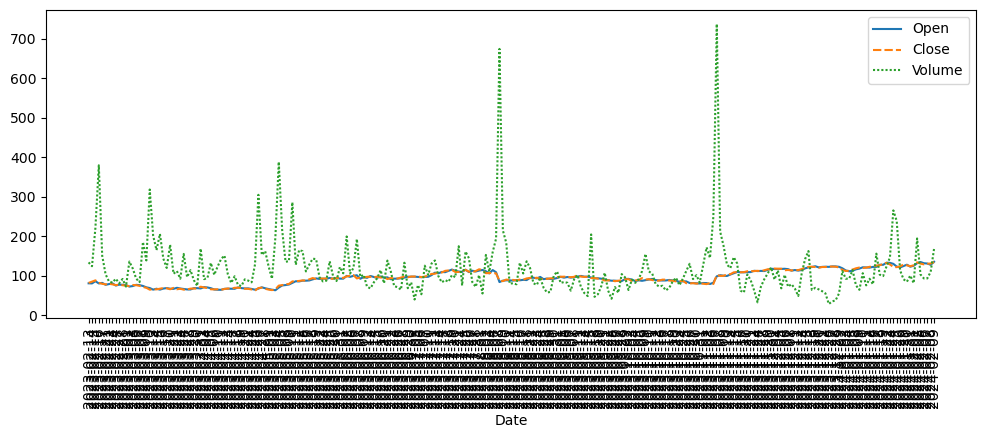

In [10]:
ddog = pd.read_csv("./DDOG.csv")
ddog.index = ddog["Date"]
ddog.drop(["Date"], axis=1, inplace=True)
ddog["Volume"] = 100 * ddog["Volume"] / ddog["Volume"].median()
ddog = ddog[["Open", "Close", "Volume"]]

plt.figure(figsize=(12, 4))
sns.lineplot(data=ddog)
plt.xticks(rotation=90)
plt.show()

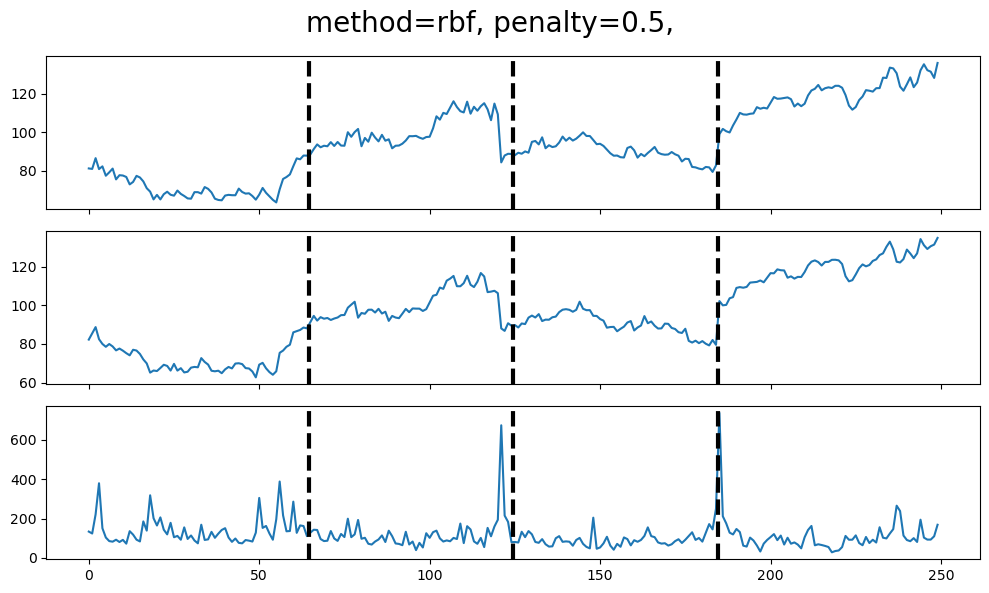

In [11]:
vizualize_change_point(ddog.values, method="rbf", pen=0.5, min_size=40)